# Importing

In [1]:
import pandas as pd
import numpy as np
import string
import pickle
import os

# from sklearn.datasets import fetch_20newsgroups

# nlp
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
# from sklearn.cluster import KMeans
# from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

# visualize
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


In [2]:
# # Define preprocessing functions
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# Helper Functions

In [3]:
def execute_model(model, model_name, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    
    #save model
    pickle.dump(model, open(f'{model_name}.sav', 'wb'))  

    Y_train_pred = model.predict(X_train)

    print(f"{model_name}:")
    # train_mse = mean_squared_error(Y_train, Y_train_pred)
    # print(f"{model_name}:\n Training MSE: {train_mse}")
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f"Train Accuracy: {train_accuracy}")

    Y_test_pred = model.predict(X_test)

    # test_mse = mean_squared_error(Y_test, Y_test_pred)
    # print(f" Testing MSE: {test_mse}")
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f"Test Accuracy: {test_accuracy}")

    draw(Y_test, Y_test_pred, model_name)

In [4]:
def draw(Y, Y_pred, model_name):
    print(classification_report(Y, Y_pred))
    # Confusion matrix
    conf_mat = confusion_matrix(Y, Y_pred)
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(model_name)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(20), set(Y), rotation=90)
    plt.yticks(np.arange(20), set(Y))
    plt.show()

In [5]:
def read_data(train_folder_path):
    X = []
    Y = []

    for class_name in os.listdir(train_folder_path):
        class_folder_path = f"{train_folder_path}/{class_name}"
        for txt_file in os.listdir(class_folder_path):
            Y.append(class_name)
            txt_file_path = f"{class_folder_path}/{txt_file}"
            X.append(open(txt_file_path, 'r').read())

    return X, Y

# Preprocessing

In [6]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [7]:
def lemmatization(tokens, tagging=False):
    lemmatized_tokens = []
    if tagging:
        tagged_tokens = nltk.pos_tag(tokens)
        for word, tag in tagged_tokens:
            if tag.startswith('NN'):    # Nouns
                lemma = lemmatizer.lemmatize(word, pos='n')
            elif tag.startswith('VB'):  # Verbs
                lemma = lemmatizer.lemmatize(word, pos='v')
            elif tag.startswith('JJ'):  # Adjectives
                lemma = lemmatizer.lemmatize(word, pos='a')
            else:
                lemma = lemmatizer.lemmatize(word)
            lemmatized_tokens.append(lemma)
    else:
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmatized_tokens

In [8]:
def stemming(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [9]:
def cleanText(tokens, choice=2):
    cleaned_text = ""

    if choice == 1: # Steaming only
        stemmed_tokens = stemming(tokens)
        cleaned_text = ' '.join(stemmed_tokens)
        # Train Accuracy: 0.936927366883548
        # Test Accuracy: 0.8762612851832182

    elif choice == 2: # Lemmatization without tagging
        lemmatized_tokens = lemmatization(tokens, False)
        cleaned_text = ' '.join(lemmatized_tokens)
        # Train Accuracy: 0.9429026689682645
        # Test Accuracy: 0.8810408921933085

    elif choice == 3: # Lemmatization with tagging
        lemmatized_tokens = lemmatization(tokens, True)
        cleaned_text = ' '.join(lemmatized_tokens)
        # Train Accuracy: 0.9408445093613066
        # Test Accuracy: 0.8802442910249602

    elif choice == 4: # Lemmatization without tagging and Steaming
        lemmatized_tokens = lemmatization(tokens, False)
        stemmed_tokens = stemming(lemmatized_tokens)
        cleaned_text = ' '.join(stemmed_tokens)
        # Train Accuracy: 0.937192935865091
        # Test Accuracy: 0.8746680828465215

    elif choice == 5: # Lemmatization with tagging and Steaming
        lemmatized_tokens = lemmatization(tokens, True)
        stemmed_tokens = stemming(lemmatized_tokens)
        cleaned_text = ' '.join(stemmed_tokens)


    return cleaned_text


In [10]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    
    cleaned_text = cleanText(tokens, 2)
    return cleaned_text

In [11]:
test_folder_path = r'20news-18828'
X, Y = read_data(test_folder_path)

In [12]:
train_news, test_news, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=70)

In [13]:
train_news_preprocessed = [preprocess_text(cleaned_text) for cleaned_text in train_news]

In [14]:
test_news_preprocessed = [preprocess_text(cleaned_text) for cleaned_text in test_news]

## Feature Extraction

### TF-IDF

In [15]:
# Compute TF-IDF for training and test data
vectorizer = TfidfVectorizer()
vectorizer.fit(train_news_preprocessed)

TfidfVectorizer()

In [16]:
X_train = vectorizer.transform(train_news_preprocessed)
X_test = vectorizer.transform(test_news_preprocessed)

# Models

## Naive Bayes

Naive Bayes:
Train Accuracy: 0.9429026689682645
Test Accuracy: 0.8810408921933085
                          precision    recall  f1-score   support

             alt.atheism       0.91      0.80      0.85       172
           comp.graphics       0.87      0.82      0.85       200
 comp.os.ms-windows.misc       0.83      0.89      0.86       182
comp.sys.ibm.pc.hardware       0.77      0.86      0.81       208
   comp.sys.mac.hardware       0.93      0.87      0.90       198
          comp.windows.x       0.91      0.88      0.90       191
            misc.forsale       0.90      0.75      0.82       204
               rec.autos       0.87      0.94      0.90       186
         rec.motorcycles       0.98      0.96      0.97       213
      rec.sport.baseball       0.96      0.95      0.96       191
        rec.sport.hockey       0.96      0.99      0.97       196
               sci.crypt       0.92      0.97      0.94       214
         sci.electronics       0.87      0.89      0.88    

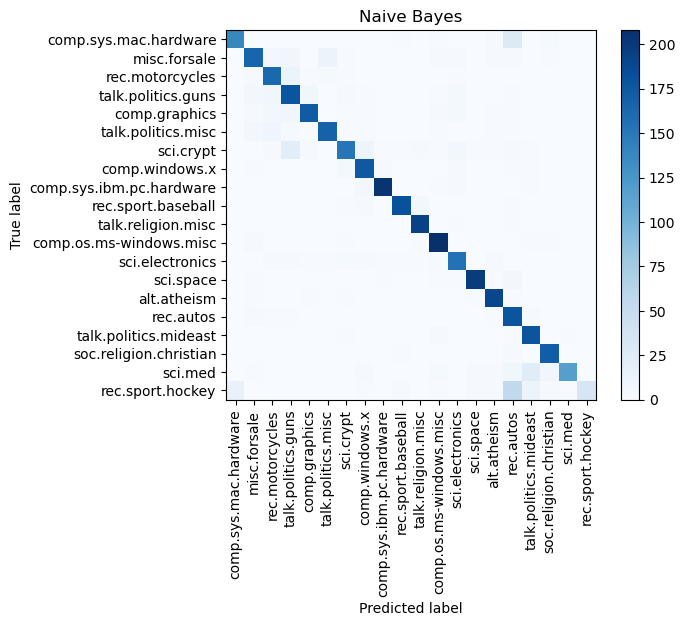

In [17]:
naive_bayes_model = MultinomialNB()
execute_model(naive_bayes_model, "Naive Bayes", X_train, Y_train, X_test, Y_test)

## Decision Tree

Decision Tree Classifier:
Train Accuracy: 0.8464347364227858
Test Accuracy: 0.6224110462028678
                          precision    recall  f1-score   support

             alt.atheism       0.69      0.55      0.61       172
           comp.graphics       0.61      0.43      0.51       200
 comp.os.ms-windows.misc       0.66      0.63      0.64       182
comp.sys.ibm.pc.hardware       0.51      0.46      0.48       208
   comp.sys.mac.hardware       0.75      0.63      0.69       198
          comp.windows.x       0.66      0.55      0.60       191
            misc.forsale       0.69      0.67      0.68       204
               rec.autos       0.74      0.55      0.63       186
         rec.motorcycles       0.85      0.76      0.80       213
      rec.sport.baseball       0.73      0.64      0.68       191
        rec.sport.hockey       0.83      0.74      0.78       196
               sci.crypt       0.89      0.74      0.81       214
         sci.electronics       0.21      0.67 

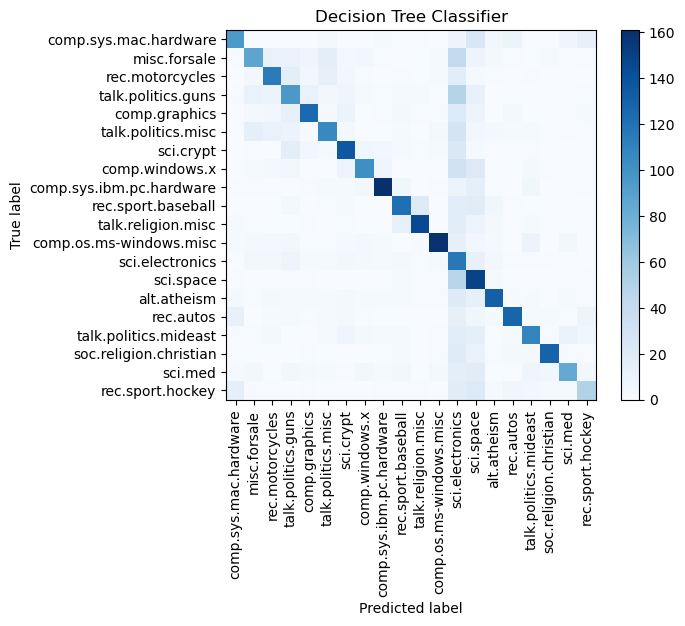

In [18]:
decision_tree_model = DecisionTreeClassifier(max_depth=80)
execute_model(decision_tree_model, "Decision Tree Classifier", X_train, Y_train, X_test, Y_test) 

# Logistic Regression

Logistic Regression:
Train Accuracy: 0.9739742398087904
Test Accuracy: 0.912639405204461
                          precision    recall  f1-score   support

             alt.atheism       0.94      0.90      0.92       172
           comp.graphics       0.84      0.83      0.84       200
 comp.os.ms-windows.misc       0.85      0.88      0.86       182
comp.sys.ibm.pc.hardware       0.82      0.85      0.84       208
   comp.sys.mac.hardware       0.91      0.91      0.91       198
          comp.windows.x       0.88      0.89      0.89       191
            misc.forsale       0.83      0.87      0.85       204
               rec.autos       0.91      0.92      0.92       186
         rec.motorcycles       0.98      0.96      0.97       213
      rec.sport.baseball       0.96      0.96      0.96       191
        rec.sport.hockey       0.98      0.96      0.97       196
               sci.crypt       0.97      0.94      0.95       214
         sci.electronics       0.86      0.93      0

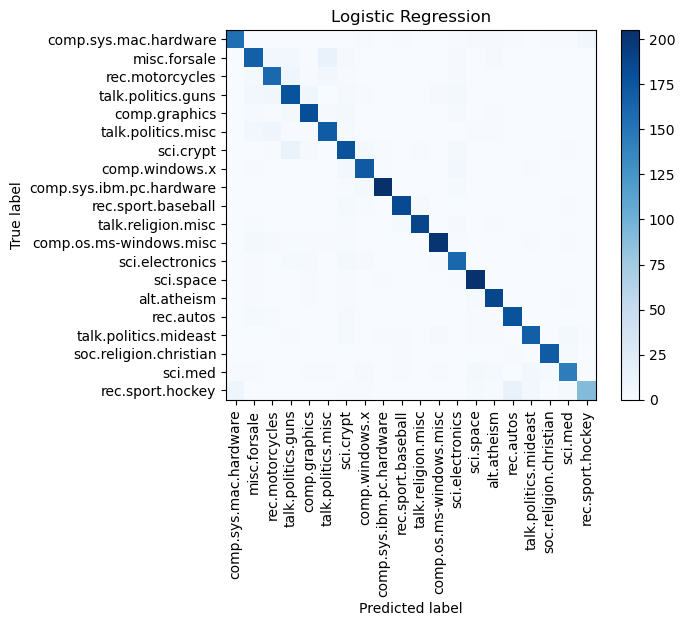

In [19]:
logistic_regression_model = linear_model.LogisticRegression()
execute_model(logistic_regression_model, "Logistic Regression", X_train, Y_train, X_test, Y_test)